In [1]:
from __future__ import absolute_import

%matplotlib inline
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import seaborn.apionly as sns
import os
import scipy.io
import scipy.sparse as sp
import numpy as np
import timeit
import comdet.pme as pme
import comdet.pme.acontrario as ac
import comdet.pme.measures as mes
import comdet.biclustering.preference as pref
import comdet.biclustering.nmf as bc
import comdet.biclustering.deflation as deflation
import comdet.test.base2d_test as base2d_test

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
n_samples = 20000
inliers_threshold = 0.03
epsilon = 0

name = 'Circles5_S00075_O50'
n_groups = 5

model_class = pme.Circle
sampler = pme.GaussianLocalSampler(n_samples, 0.5)

examples = scipy.io.loadmat('comdet/data/JLinkageExamples.mat')
x = examples[name].T

gt_groups = base2d_test.ground_truth(x.shape[0], n_groups=n_groups,
                                     group_size=50)

Preference matrix size: (500, 621)


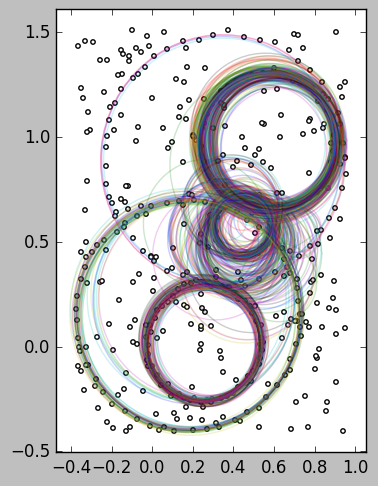

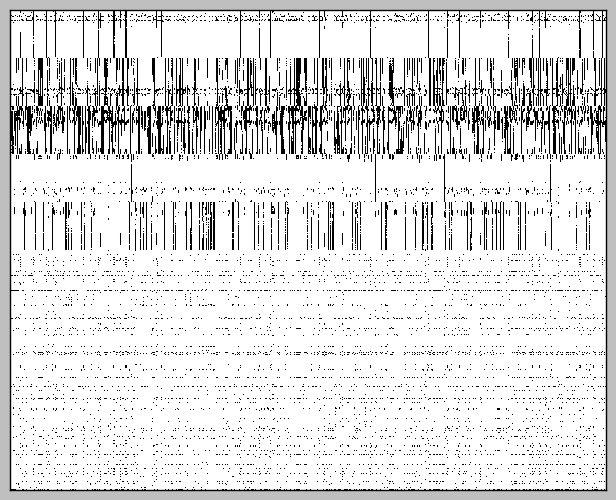

In [3]:
np.random.seed(11)
output_prefix = 'comdet/results/' + name

mdg = pme.model_distance_generator(model_class, x, sampler)
ig = pme.inliers_generator(mdg, inliers_threshold)

def meaningful((model, inliers)):
    return ac.meaningful(x, model, inliers, inliers_threshold, epsilon)

preference_matrix = pref.create_preference_matrix(x.shape[0])
original_models = []
for i, (model, inliers) in enumerate(ac.filter_meaningful(meaningful, ig)):
    preference_matrix = pref.add_col(preference_matrix, inliers)
    original_models.append(model)

base2d_test.plot_models(x, original_models, alpha=0.2)

print 'Preference matrix size:', preference_matrix.shape

plt.figure()
pref.plot_preference_matrix(preference_matrix)
plt.show()

In [4]:
t = timeit.default_timer()
online_deflator = deflation.Deflator(preference_matrix)
bic_list = bc.bicluster(online_deflator)
t1 = timeit.default_timer() - t
print 'Time:', t1

Time: 49.7987501621


In [6]:
base2d_test.clean(model_class, x, bic_list, inliers_threshold, epsilon)

TypeError: clean() takes exactly 10 arguments (5 given)

In [ ]:
t = timeit.default_timer()
compression_level = 128
online_deflator = deflation.L1CompressedDeflator(preference_matrix,
                                                 compression_level)
bic_list = bc.bicluster(online_deflator, n=17)
t1 = timeit.default_timer() - t
print 'Time:', t1

In [ ]:
clean_and_plot(model_class, x, preference_matrix, original_models, bic_list,
               inliers_threshold, epsilon, output_prefix + '_bic_comp', gt_groups)